In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

sns.set_context('talk')
## define the same random seed for future use
RND = 722
KFOLD_ITER = 5

**Note:**

Data source: [hotel demand datasets](https://ars.els-cdn.com/content/image/1-s2.0-S2352340918315191-mmc2.zip) from Antonio, et al. (2019).

Paper: Antonio, N., De Almeida, A., & Nunes, L. (2019). Hotel booking demand datasets. Data in Brief, 22, 41-49. https://doi.org/10.1016/j.dib.2018.11.126

# 5. Data Mining Method Selection

Supervised learning: classification task.


# 6. Data Mining Algorithm Selection

- Logistic Regression
- Decision Tree
- Random Forest
- XGBoost Tree
- Gradient Boosted Trees

# 7. Data Mining

## 7.1. Create and Justify Test Designs

Train-validation-test. Use k-fold cross validation to estimate the performance in validation set.

In [2]:
## prepared & transformed:
df_hotel = pd.read_csv("hotel_merged_data_transformation.csv")

In [3]:
## we have split the training and test data into 70:30 before feature selection and oversampling
## we use the same split
mask_train = (df_hotel['IsTrainSet'] == 1)
EXCLUDED_FEATURE_COLS = ['IsCanceled','IsTrainSet']
mask_feature_cols = df_hotel.columns[~(df_hotel.columns.isin(EXCLUDED_FEATURE_COLS))]

X_train = df_hotel[mask_train][mask_feature_cols]
y_train = df_hotel[mask_train]['IsCanceled']

X_test = df_hotel[~mask_train][mask_feature_cols]
y_test = df_hotel[~mask_train]['IsCanceled']

## 7.2. Conduct Data Mining

Algorithms:
- Logistic Regression
- Decision Tree
- Random Forest
- XGBoost
- Gradient-Boosted Decision Tree

These models are evaluated based on accuracy and AUC.

In [4]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import roc_auc_score

def evaluate_performance(y_true, y_pred, print_results = True):
    accuracy = accuracy_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred)
    
    if print_results:
        print("Accuracy : {:,.3%}".format(accuracy))
        print("AUC: {:,.3f}".format(auc))
        print(classification_report(y_true, y_pred))
        
    return accuracy, auc

In [5]:
from sklearn.model_selection import KFold

def kfold_cv(clf, X_train, y_train, k = 10):
    kfold = KFold(random_state = RND, shuffle = True, n_splits = k)
    
    cv_accuracy = np.zeros(shape = k)
    cv_auc = np.zeros(shape = k)
    
    i = 0
    for train_index, val_index in kfold.split(X_train):
        X_tr = X_train.loc[train_index]
        y_tr = y_train.loc[train_index]
        X_val = X_train.loc[val_index]
        y_val = y_train.loc[val_index]
        
        clf.fit(X_tr, y_tr)
        y_pred = clf.predict(X_val)
        accuracy, auc = evaluate_performance(y_val, y_pred, print_results = False)
        
        cv_accuracy[i] = accuracy
        cv_auc[i] = auc
        
        i += 1
    
    print("Cross-validation results")
    print("========================")
    print("Accuracy: {:,.3%}".format(np.mean(cv_accuracy), np.std(cv_accuracy)))
    print("AUC: {:,.3f}".format(np.mean(cv_auc), np.std(cv_auc)))

### Logistic Regression

In [6]:
from sklearn.linear_model import LogisticRegression

logres = LogisticRegression(random_state = RND, max_iter = 100, solver = 'newton-cg')

## Perform k-fold cross-validation
kfold_cv(logres, X_train, y_train, k = KFOLD_ITER)

## Train with the whole training set
logres.fit(X_train, y_train)

/home/elvyna/miniconda3/envs/py37/lib/python3.7/site-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/elvyna/miniconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


Cross-validation results
Accuracy: 75.426%
AUC: 0.754


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=722, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

In [7]:
y_pred = logres.predict(X_test)
accuracy, auc = evaluate_performance(y_test, y_pred)

Accuracy : 74.547%
AUC: 0.748
              precision    recall  f1-score   support

       False       0.84      0.74      0.78     22493
        True       0.63      0.76      0.69     13322

    accuracy                           0.75     35815
   macro avg       0.73      0.75      0.74     35815
weighted avg       0.76      0.75      0.75     35815



### Decision Tree

In [8]:
from sklearn.tree import DecisionTreeClassifier

dtree = DecisionTreeClassifier(random_state = RND)

## Perform k-fold cross-validation
kfold_cv(dtree, X_train, y_train, k = KFOLD_ITER)

## Train with the whole training set
dtree.fit(X_train, y_train)

Cross-validation results
Accuracy: 81.686%
AUC: 0.817


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=722, splitter='best')

In [9]:
y_pred = dtree.predict(X_test)
accuracy, auc = evaluate_performance(y_test, y_pred)

Accuracy : 80.824%
AUC: 0.802
              precision    recall  f1-score   support

       False       0.86      0.83      0.84     22493
        True       0.73      0.78      0.75     13322

    accuracy                           0.81     35815
   macro avg       0.79      0.80      0.80     35815
weighted avg       0.81      0.81      0.81     35815



### Random Forest

In [10]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state = RND)

## Perform k-fold cross-validation
kfold_cv(rf, X_train, y_train, k = KFOLD_ITER)

## Train with the whole training set
rf.fit(X_train, y_train)

Cross-validation results
Accuracy: 86.043%
AUC: 0.860


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=722,
                       verbose=0, warm_start=False)

In [11]:
y_pred = rf.predict(X_test)
accuracy, auc = evaluate_performance(y_test, y_pred)

Accuracy : 84.850%
AUC: 0.840
              precision    recall  f1-score   support

       False       0.89      0.87      0.88     22493
        True       0.79      0.81      0.80     13322

    accuracy                           0.85     35815
   macro avg       0.84      0.84      0.84     35815
weighted avg       0.85      0.85      0.85     35815



### XGBoost

In [12]:
from xgboost import XGBClassifier

xgb = XGBClassifier(random_state = RND)

## Perform k-fold cross-validation
kfold_cv(xgb, X_train, y_train, k = KFOLD_ITER)

## Train with the whole training set
xgb.fit(X_train, y_train)

Cross-validation results
Accuracy: 82.987%
AUC: 0.830


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=722, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [13]:
y_pred = xgb.predict(X_test)
accuracy, auc = evaluate_performance(y_test, y_pred)

Accuracy : 81.798%
AUC: 0.810
              precision    recall  f1-score   support

       False       0.87      0.84      0.85     22493
        True       0.74      0.78      0.76     13322

    accuracy                           0.82     35815
   macro avg       0.80      0.81      0.81     35815
weighted avg       0.82      0.82      0.82     35815



### GBDT

In [14]:
import lightgbm as lgbm

gbdt = lgbm.LGBMClassifier(random_state = RND)

## Perform k-fold cross-validation
kfold_cv(gbdt, X_train, y_train, k = KFOLD_ITER)

## Train with the whole training set
gbdt.fit(X_train, y_train)

Cross-validation results
Accuracy: 81.812%
AUC: 0.818


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=722, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [15]:
y_pred = gbdt.predict(X_test)
accuracy, auc = evaluate_performance(y_test, y_pred)

Accuracy : 80.988%
AUC: 0.801
              precision    recall  f1-score   support

       False       0.86      0.84      0.85     22493
        True       0.73      0.77      0.75     13322

    accuracy                           0.81     35815
   macro avg       0.80      0.80      0.80     35815
weighted avg       0.81      0.81      0.81     35815



## 7.3. Search for Patterns

### Logistic Regression

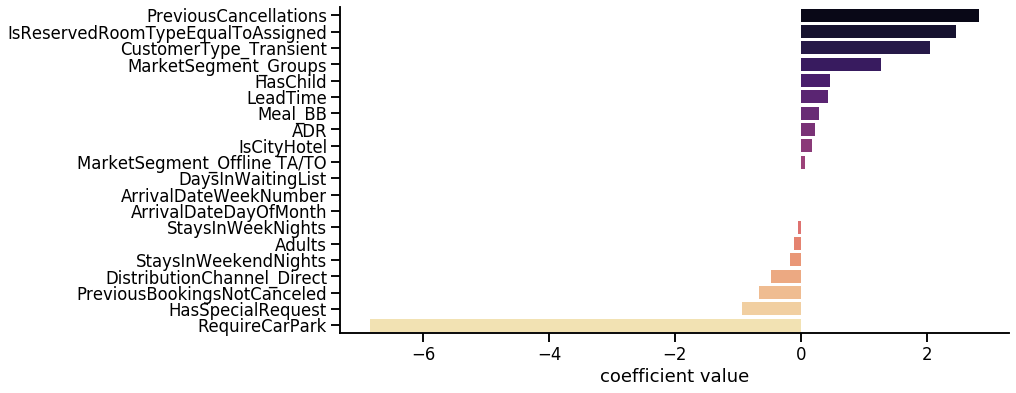

In [16]:
logres_coef = pd.DataFrame(
    data = {
        'feature_name': X_train.columns,
        'coef': logres.coef_[0]
    }
).sort_values(by='coef', ascending=False)
logres_coef['coef_abs'] = np.abs(logres_coef['coef'])


f, ax = plt.subplots(figsize = (12,6))
sns.barplot(
    data = logres_coef,
    y = 'feature_name',
    x = 'coef',
    orient = 'h',
    palette = 'magma',
    ax = ax
);

plt.xlabel('coefficient value')
plt.ylabel('')
sns.despine();

### Decision Tree

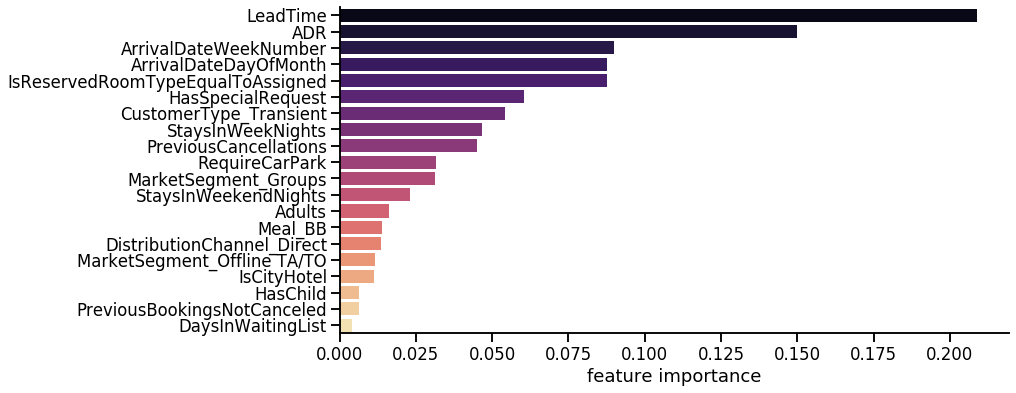

In [17]:
dtree_features = pd.DataFrame(
    data = {
        'feature_name': X_train.columns,
        'feature_importance': dtree.feature_importances_
    }
).sort_values(by='feature_importance', ascending=False)

f, ax = plt.subplots(figsize = (12,6))
sns.barplot(
    data = dtree_features,
    y = 'feature_name',
    x = 'feature_importance',
    orient = 'h',
    palette = 'magma',
    ax = ax
);

plt.xlabel('feature importance')
plt.ylabel('')
sns.despine();

### Random Forest

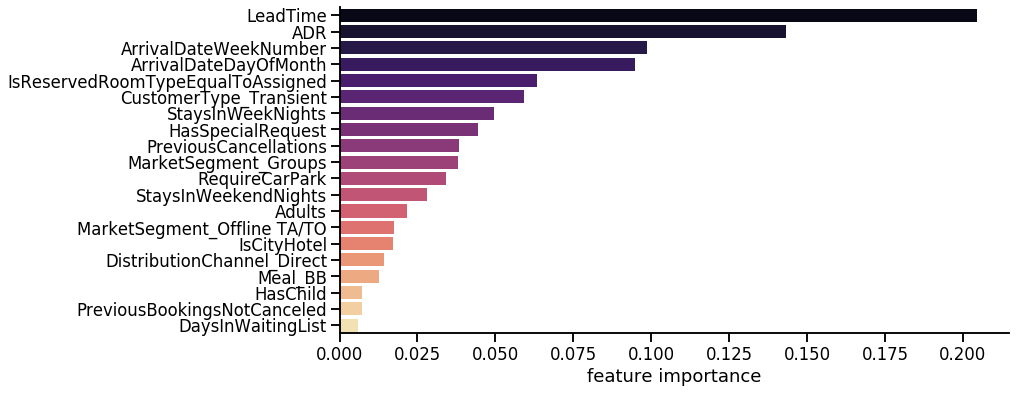

In [18]:
rf_features = pd.DataFrame(
    data = {
        'feature_name': X_train.columns,
        'feature_importance': rf.feature_importances_
    }
).sort_values(by='feature_importance', ascending=False)

f, ax = plt.subplots(figsize = (12,6))
sns.barplot(
    data = rf_features,
    y = 'feature_name',
    x = 'feature_importance',
    orient = 'h',
    palette = 'magma',
    ax = ax
);

plt.xlabel('feature importance')
plt.ylabel('')
sns.despine();

### XGBoost

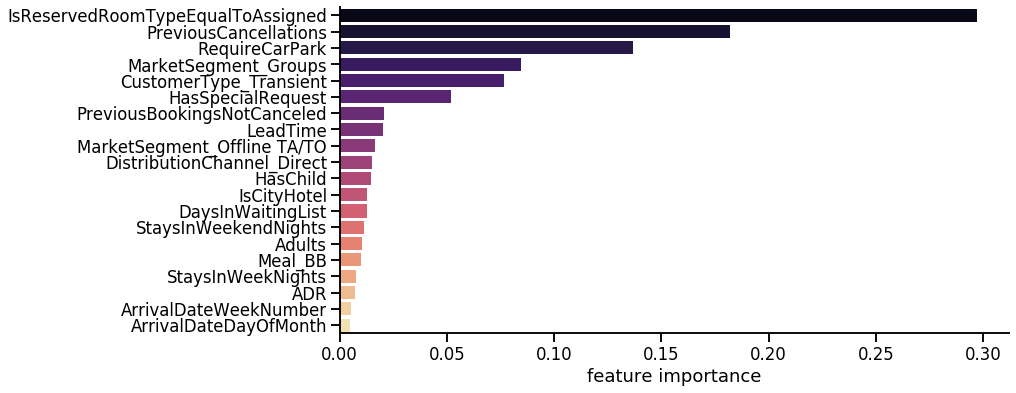

In [19]:
xgb_features = pd.DataFrame(
    data = {
        'feature_name': X_train.columns,
        'feature_importance': xgb.feature_importances_
    }
).sort_values(by='feature_importance', ascending=False)

f, ax = plt.subplots(figsize = (12,6))
sns.barplot(
    data = xgb_features,
    y = 'feature_name',
    x = 'feature_importance',
    orient = 'h',
    palette = 'magma',
    ax = ax
);

plt.xlabel('feature importance')
plt.ylabel('')
sns.despine();

### GBDT

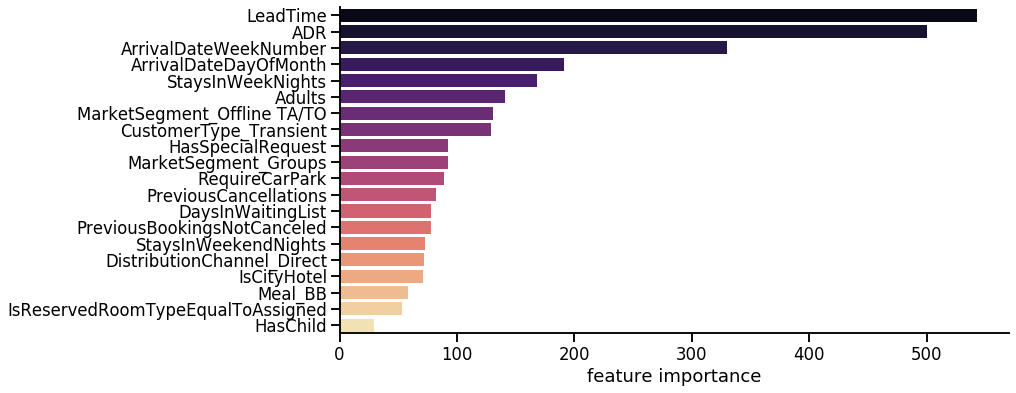

In [20]:
gbdt_features = pd.DataFrame(
    data = {
        'feature_name': X_train.columns,
        'feature_importance': gbdt.feature_importances_
    }
).sort_values(by='feature_importance', ascending=False)

f, ax = plt.subplots(figsize = (12,6))
sns.barplot(
    data = gbdt_features,
    y = 'feature_name',
    x = 'feature_importance',
    orient = 'h',
    palette = 'magma',
    ax = ax
);

plt.xlabel('feature importance')
plt.ylabel('')
sns.despine();

# 8. Interpretation

## 8.1. Study and Discuss the Mined Patterns


We extract the top 5 important features based on each model, as displayed below. There are some intersections of the top features, e.g., LeadTime is considered important in Decision Tree, Random Forest, and GBDT.

In [21]:
TOP_N_FEATURES = 5
FEATURE_NAME_COL = 'feature_name'

logres_top_features = logres_coef.sort_values(
    by = 'coef_abs', 
    ascending = False
).head(TOP_N_FEATURES)[FEATURE_NAME_COL].values

df_top_features = pd.DataFrame(
    data = {
        'logistic_regression': logres_top_features,
        'decision_tree': dtree_features.head(TOP_N_FEATURES)[FEATURE_NAME_COL].values,
        'random_forest': rf_features.head(TOP_N_FEATURES)[FEATURE_NAME_COL].values,
        'xgboost': xgb_features.head(TOP_N_FEATURES)[FEATURE_NAME_COL].values,
        'gbdt': gbdt_features.head(TOP_N_FEATURES)[FEATURE_NAME_COL].values
    }
)

df_top_features

,logistic_regression,decision_tree,random_forest,xgboost,gbdt
0,RequireCarPark,LeadTime,LeadTime,IsReservedRoomTypeEqualToAssigned,LeadTime
1,PreviousCancellations,ADR,ADR,PreviousCancellations,ADR
2,IsReservedRoomTypeEqualToAssigned,ArrivalDateWeekNumber,ArrivalDateWeekNumber,RequireCarPark,ArrivalDateWeekNumber
3,CustomerType_Transient,ArrivalDateDayOfMonth,ArrivalDateDayOfMonth,MarketSegment_Groups,ArrivalDateDayOfMonth
4,MarketSegment_Groups,IsReservedRoomTypeEqualToAssigned,IsReservedRoomTypeEqualToAssigned,CustomerType_Transient,StaysInWeekNights


There are 10 unique features.

In [22]:
from itertools import chain

top_features = set(chain(*df_top_features.values))
top_features

{'ADR',
 'ArrivalDateDayOfMonth',
 'ArrivalDateWeekNumber',
 'CustomerType_Transient',
 'IsReservedRoomTypeEqualToAssigned',
 'LeadTime',
 'MarketSegment_Groups',
 'PreviousCancellations',
 'RequireCarPark',
 'StaysInWeekNights'}

## 8.2. Visualise the Data, Results, Models, Patterns

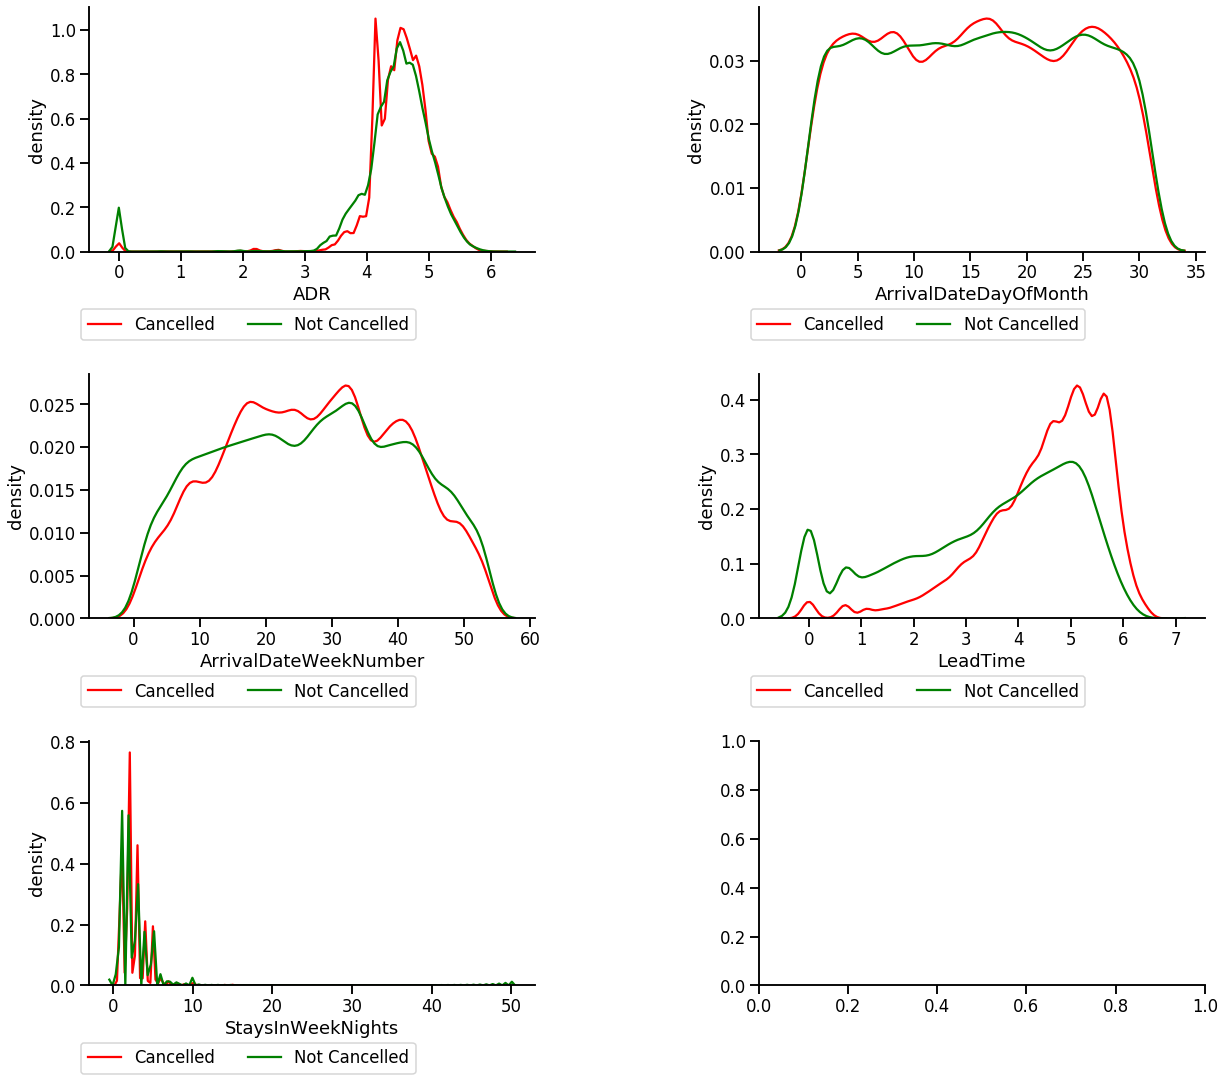

In [23]:
mask_cancelled = (df_hotel['IsCanceled'] == True)
numeric_cols = ['ADR','ArrivalDateDayOfMonth','ArrivalDateWeekNumber','LeadTime','StaysInWeekNights']

f, ax = plt.subplots(figsize = (20, 18), ncols = 2, nrows = 3)
plt.subplots_adjust(wspace = .5, hspace = .5)

i = 0
j = 0
for col in numeric_cols:
    sns.distplot(
        df_hotel[mask_cancelled][col],
        label = 'Cancelled',
        color = 'red',
        hist = False,
        ax = ax[i][j]
    )

    sns.distplot(
        df_hotel[~mask_cancelled][col],
        label = 'Not Cancelled',
        color = 'green',
        hist = False,
        ax = ax[i][j]
    )
    
    ax[i][j].legend(bbox_to_anchor = [.75, -.2], ncol = 2);
    ax[i][j].set_ylabel('density')
    
    if (j % 2 == 1):
        j = 0
        i += 1
    else:
        j += 1

sns.despine();

In [24]:
df_hotel.groupby('IsCanceled').agg({
    'CustomerType_Transient': 'mean',
    'IsReservedRoomTypeEqualToAssigned': 'mean',
    'MarketSegment_Groups': 'mean',
    'RequireCarPark': 'mean',
    'PreviousCancellations': [np.mean, np.std, np.median],
    'StaysInWeekNights': [np.mean, np.std, np.median]
})

CustomerType_Transient IsReservedRoomTypeEqualToAssigned  \
                             mean                              mean   
IsCanceled                                                            
False                    0.706429                          0.812224   
True                     0.844287                          0.986726   

           MarketSegment_Groups RequireCarPark PreviousCancellations  \
                           mean           mean                  mean   
IsCanceled                                                             
False                  0.102616       0.098651              0.015792   
True                   0.292516       0.000000              0.200658   

                            StaysInWeekNights                   
                 std median              mean       std median  
IsCanceled                                                      
False       0.272425      0          2.463999  1.924785      2  
True        1.336839      0          2.456064  1.760431      2

## 8.3. Interpret the Results, Models, Patterns

Cancelled bookings:
- have bimodal ADR distribution
- have longer lead time
- are observed more frequently around the 18th week of year (start of Q2)
- are observed more on Groups market segment
- NOT observed on bookings that require car park
- observed more frequently on customers with more historical booking cancellations

## 8.4. Assess and Evaluate the Results, Models, Patterns

In [25]:
from sklearn.metrics import plot_roc_curve

def display_roc_curve(clfs, X, y, axis = None):
    for clf in clfs:
        plot_roc_curve(
            clf,
            X,
            y,
            ax = axis
        )

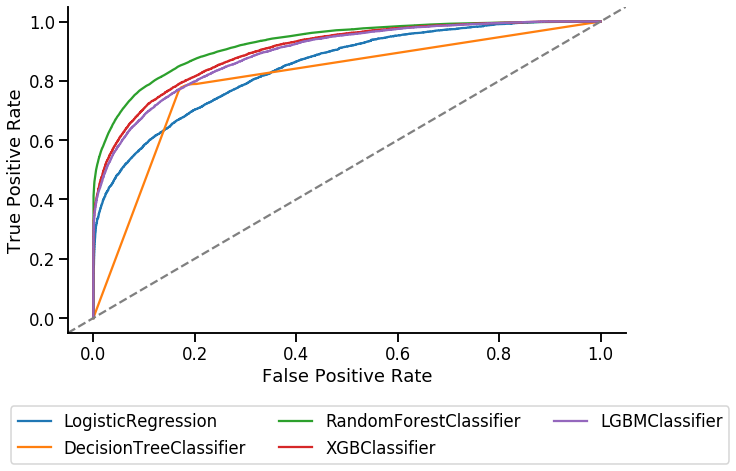

In [27]:
f, ax = plt.subplots(figsize = (10, 6))

clfs = [logres, dtree, rf, xgb, gbdt]
display_roc_curve(
    clfs, 
    X_test,
    y_test,
    axis = ax
)

ax.plot(
    [0, 1], 
    [0, 1], 
    transform = ax.transAxes,
    linestyle = 'dashed',
    color = 'grey'
)

plt.legend(
    bbox_to_anchor = [1.2, -0.2],
    ncol = 3,
    labels = [
        clf.__class__.__name__ for clf in clfs
    ]
)

sns.despine();